### Задача

Обучить модель.

### Гипотеза

Обучение на датасете, где применяли аугментацию из списка, одна функция на одно изображение.

In [1]:
import torch
torch.__version__

'1.13.0+cu117'

In [2]:
name_experiment = 'augoff'

### Constants

In [3]:
import json



path_anns = '../data/dataset/annotations/default.json'

with open(path_anns, 'r') as f:
    data = json.load(f)

list_labels = [d['name'] for d in data['categories']['label']['labels']]
print(list_labels)

['room', 'bathroom', 'inner_corridor', 'public_place', 'floor_finish', 'floor_init', 'ceiling_finish', 'wall_finish', 'wall_init', 'door_room', 'toilet_yes', 'bath_yes', 'esocket_yes', 'kitchen_furniture_yes', 'radiator', 'floor_without', 'ceiling_without', 'wall_without', 'window_trim', 'window', 'floor_pipes', 'garbage', 'place_door', 'place_radiator', 'ventilation_shaft', 'sink_yes', 'conditioner', 'smoke_detector', 'ventilation_grille', 'fire_detectors', 'dynamics', 'switch_box_flat', 'switch_box_public', 'xbk', 'water_pipes_mop', 'water_pipes_flat', 'water_meter', 'heating_riser', 'smoke_exhaust_valve', 'electrical_cable', 'electrical_riser', 'lamp', 'door_mop', 'door_entrance', 'socket_box', 'tongue_groove_blocks', 'tile_plinth', 'pantry', 'bad_light']


In [4]:
n_classes = len(list_labels)
device = 'cuda:1'

lr = 5e-4
epochs = 10
batch_size = 688
layers_to_unfreeze = 2

threshold = 0.5

### Init model

In [5]:
import timm

timm.list_models('convnext*', pretrained=True)

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

Инициализируем модель и посмотрим конфигурации модели при тренировки, чтобы добавить их в трансформации.

In [6]:
model = timm.create_model('convnext_large_in22k', pretrained=True, num_classes=n_classes)
model.default_cfg

{'url': 'https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth',
 'num_classes': 21841,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'stem.0',
 'classifier': 'head.fc',
 'architecture': 'convnext_large_in22k'}

Посмотрим количество параметров модели.

In [7]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Количество параметров модели: {round(total_params / 1000000)} МЛ')

Количество параметров модели: 196 МЛ


### Transforms

In [6]:
import albumentations as A
import albumentations.pytorch



train_transforms = A.Compose(
                                [
                                    A.Resize(width=224, height=224),        
                                    A.Normalize(
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225],
                                        max_pixel_value=255.0,
                                    ),
                                    
                                    A.pytorch.ToTensorV2()
    ]
)

val_transforms = A.Compose(
                                [
                                    A.Resize(width=224, height=224),
                                    A.Normalize(
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225],
                                            max_pixel_value=255.0,
                                        ),

                                    A.pytorch.ToTensorV2()
    ]
)

test_transforms = val_transforms

### Dataset

In [7]:
import cv2
import torch
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader



class ImageDataset(Dataset):
    def __init__(self, path_csv: str, path_imgs: str, transforms=None):
        """
        :param path_imgs: path to image folder.
        """

        self.df = pd.read_csv(path_csv)
        self.path_imgs = path_imgs
        self.transforms = transforms
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        file_name = self.df.iloc[index, 0]
        path_img = f'{self.path_imgs}/{file_name}.jpg'

        img = cv2.imread(path_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            transformered = self.transforms(image=img)
            img = transformered['image']
            
        
        targets = self.df.iloc[index, 1:]
        targets = torch.tensor(targets, dtype=torch.float32)
        
        return {
            'image': img,
            'targets': targets,
            'path_img': path_img
        }

### Metrics

In [8]:
import numpy as np



def get_f1(preds: torch.tensor, targets: torch.tensor):
    
    e = 1e-10
        
    TP = sum(targets[preds == 1] == 1)
    FP = sum(targets[preds == 1] == 0)
    FN = sum(targets[preds == 0] == 1)
    
    precision = TP / (TP + FP + e)
    recall = TP / (TP + FN + e)
    f1 = 2 * precision * recall / (precision + recall + e)
    
    return round(f1, 2)

In [9]:
def get_subf1(
    preds: torch.tensor,
    targets: torch.tensor
) -> np.array:

    batch_subf1 = []
    for axis in range(targets.shape[-1]):
        subtargets = targets[:, axis]
        subpreds = preds[:, axis]
        subf1 = get_f1(subpreds, subtargets)
        batch_subf1.append(subf1)

    return batch_subf1

### Functions

In [10]:
from tqdm import tqdm



def train(model, dataloader, optimizer, criterion, device, threshold, n_classes):
    
    losses = []
    f1s = []
    all_preds = np.array([]).reshape(0, n_classes) 
    all_targets = np.array([]).reshape(0, n_classes)
    
    model.train()
    for data in tqdm(dataloader, total=len(dataloader)):
        
        data, targets = data['image'].to(device), data['targets'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        outputs = torch.sigmoid(outputs)
        preds = torch.where(outputs > threshold, 1, 0)
                        
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        all_preds = np.vstack((all_preds, preds.detach().cpu()))
        all_targets = np.vstack((all_targets, targets.detach().cpu()))
        
    train_loss = np.mean(losses)
    train_micro_f1 = get_f1(all_preds, all_targets)
    train_micro_subf1 = get_subf1(all_preds, all_targets)
    train_macro_f1 = sum(train_micro_subf1) / n_classes
    
    return train_loss, train_micro_f1, train_micro_subf1, train_macro_f1

In [11]:
def validate(model, dataloader, criterion, device, threshold, n_classes):
    
    losses = []
    f1s = []
    all_preds = np.array([]).reshape(0, n_classes) 
    all_targets = np.array([]).reshape(0, n_classes)
    
    model.eval()
    with torch.no_grad():
        for data in tqdm(dataloader, total=len(dataloader)):
            data, targets = data['image'].to(device), data['targets'].to(device)
            
            outputs = model(data)
            outputs = torch.sigmoid(outputs)
            preds = torch.where(outputs > threshold, 1, 0)

            all_preds = np.vstack((all_preds, preds.detach().cpu()))
            all_targets = np.vstack((all_targets, targets.detach().cpu()))
            
            loss = criterion(outputs, targets)
            losses.append(loss.item())
        
    val_loss = np.mean(losses)
    val_micro_f1 = get_f1(all_preds, all_targets)
    val_micro_subf1 = get_subf1(all_preds, all_targets)
    val_macro_f1 = sum(val_micro_subf1) / n_classes
        
    return val_loss, val_micro_f1, val_micro_subf1, val_macro_f1

In [12]:
def set_parameter_requires_grad(model, layers_to_unfreeze):
    for param in model.parameters():
        param.requires_grad = True
    for param in list(model.parameters())[:-layers_to_unfreeze]:
        param.requires_grad = False

In [13]:
def get_training_layers(model):

    params_to_update = model.parameters()

    print('Params to learn:')
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print('\t', name)

    return params_to_update

In [14]:
def save_model(epochs, model, optimizer, criterion, path):
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, path)

In [15]:
import matplotlib.pyplot as plt



def save_plot(name_metric: str, train: list, val: list, path_save_plot: str) -> None:
    plt.figure(figsize=(10, 7))
    plt.plot(train, color='orange', label=f'train {name_metric}')
    plt.plot(val, color='red', label=f'val {name_metric}')
    plt.xticks(range(len(train)))
    plt.xlabel('Epochs')
    plt.ylabel(name_metric)
    plt.legend()
    plt.savefig(path_save_plot)
    plt.show()

Если появились изменения в составе лейблов, необходимо убедиться, что название лейблов и цветов и их количество соответствует нововведениям.

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [19]:
all_num_labels = 49

In [20]:
def save_plot_subf1(val_micro_subf1s: list, name_metric: str, path_save_plot: str) -> None:

    stacked = np.vstack(val_micro_subf1s)
    num_epochs = stacked.shape[0]

    list_labels = [
        'room', 'bathroom', 'inner_corridor', 'public_place', 'floor_finish',
        'floor_init', 'ceiling_finish', 'wall_finish', 'wall_init',
        'door_room', 'toilet_yes', 'bath_yes', 'esocket_yes',
        'kitchen_furniture_yes', 'radiator', 'floor_without',
        'ceiling_without', 'wall_without', 'window_trim', 'window',
        'floor_pipes', 'garbage', 'place_door', 'place_radiator',
        'ventilation_shaft', 'sink_yes', 'conditioner', 'smoke_detector',
        'ventilation_grille', 'fire_detectors', 'dynamics', 'switch_box_flat',
        'switch_box_public', 'xbk', 'water_pipes_mop', 'water_pipes_flat',
        'water_meter', 'heating_riser', 'smoke_exhaust_valve',
        'electrical_cable', 'electrical_riser', 'lamp', 'door_mop',
        'door_entrance', 'socket_box', 'tongue_groove _blocks', 'tile_plinth',
        'pantry', 'bad_light'
    ]

    colors = list(mcolors.CSS4_COLORS.values())[:all_num_labels]

    plt.figure(figsize=(10, 7))

    for i, label in enumerate(list_labels):
        plt.plot(stacked[:, i], color=colors[i], label=f'{label}')

    plt.title('Val')
    plt.xticks(range(num_epochs))
    plt.xlabel('Epochs')
    plt.ylabel(name_metric)
    plt.legend()
    plt.savefig(path_save_plot)
    plt.show()

### Dataloader

In [21]:
path_imgs_train = '../data/dataset/combined/augoff/images'
path_imgs_val = '../data/dataset/combined/images/default'

path_csv_train = '../data/dataset/combined/augoff/annotations/train.csv'
path_csv_val = '../data/dataset/combined/csv/val.csv'

ds_train = ImageDataset(path_csv_train, path_imgs_train, train_transforms)
ds_val = ImageDataset(path_csv_val, path_imgs_val, val_transforms)

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)

### Preparation

In [22]:
import torch.nn as nn
import torch.optim as optim

In [23]:
set_parameter_requires_grad(model, layers_to_unfreeze)
params_to_update = get_training_layers(model)

Params to learn:
	 head.fc.weight
	 head.fc.bias


In [24]:
model.to(device)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=768, out_features=192, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (norm): LayerNorm((192,), eps=1e-06, elemen

In [25]:
optimizer = optim.Adam(params_to_update, lr=lr)
criterion = nn.BCELoss()

### Train

In [ ]:
import os
import shutil

dir_logs = f'../logs/{name_experiment}'

if os.path.exists(dir_logs):
    shutil.rmtree(dir_logs)

if not os.path.exists(dir_logs):
    os.makedirs(dir_logs)
    
best_macro_f1 = 0
train_losses, val_losses = [], []
train_micro_f1s, val_micro_f1s = [], []
train_macro_f1s, val_macro_f1s = [], []
val_micro_subf1s = []

for epoch in range(epochs):
    
    print(f"Epoch {epoch+1} of {epochs}")
    
    train_loss, train_micro_f1, train_micro_subf1, train_macro_f1 = train(
                                                                            model,
                                                                            dl_train,
                                                                            optimizer,
                                                                            criterion,
                                                                            device,
                                                                            threshold,
                                                                            n_classes
    )
    
    val_loss, val_micro_f1, val_micro_subf1, val_macro_f1 = validate(
                                                                        model,
                                                                        dl_val,
                                                                        criterion,
                                                                        device,
                                                                        threshold,
                                                                        n_classes
    )
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    train_micro_f1s.append(train_micro_f1)
    val_micro_f1s.append(val_micro_f1)
    
    train_macro_f1s.append(train_macro_f1)
    val_macro_f1s.append(val_macro_f1)
    
    val_micro_subf1s.append(val_micro_subf1)
    
    print(f"Train macro f1: {train_macro_f1:.3f} | loss: {train_loss}")
    
    print(f'Val macro f1: {val_macro_f1:.3f} | loss {val_loss}')
            
    if best_macro_f1 < val_macro_f1:
        
        cur_best_weights = f'{dir_logs}/{name_experiment}_prec_{best_macro_f1:.3f}.pth'
        
        if os.path.exists(cur_best_weights):
            os.remove(cur_best_weights)
               
        path_best_weights = f'{dir_logs}/{name_experiment}_prec_{val_macro_f1:.3f}.pth'
        
        save_model(epochs, model, optimizer, criterion, path_best_weights)
        best_macro_f1 = val_macro_f1.copy()


save_plot(
    name_metric='loss',
    train=train_losses,
    val= val_losses,
    path_save_plot = f'../logs/{name_experiment}/losses.jpg'
)

save_plot(
    name_metric='micro_f1',
    train=train_micro_f1s,
    val= val_micro_f1s,
    path_save_plot = f'../logs/{name_experiment}/micro_f1.jpg'
)

save_plot(
    name_metric='macro_f1',
    train=train_macro_f1s,
    val= val_macro_f1s,
    path_save_plot = f'../logs/{name_experiment}/macro_f1.jpg'
)

save_plot_subf1(
    val_micro_subf1s,
    name_metric='micro f1',
    path_save_plot=f'../logs/{name_experiment}/micro_subf1.jpg'
)

Epoch 1 of 10


 67%|██████▋   | 2/3 [01:24<00:42, 42.41s/it]Corrupt JPEG data: 43 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
100%|██████████| 3/3 [02:04<00:00, 41.57s/it]


Train macro f1: 0.537 | loss: 0.14777327447712837
Val macro f1: 0.649 | loss 0.11400499194860458
Epoch 2 of 10


 31%|███       | 220/715 [2:32:06<5:46:04, 41.95s/it]

### Inference

In [31]:
import json

path_anns = '../data/dataset/annotations/default.json'

with open(path_anns, 'r') as f:
    data = json.load(f)

list_labels = [d['name'] for d in data['categories']['label']['labels']]
print(list_labels)

['room', 'bathroom', 'inner_corridor', 'public_place', 'floor_finish', 'floor_init', 'ceiling_finish', 'wall_finish', 'wall_init', 'door_room', 'toilet_yes', 'bath_yes', 'esocket_yes', 'kitchen_furniture_yes', 'radiator', 'floor_without', 'ceiling_without', 'wall_without', 'window_trim', 'window', 'floor_pipes', 'garbage', 'place_door', 'place_radiator', 'ventilation_shaft', 'sink_yes', 'conditioner', 'smoke_detector', 'ventilation_grille', 'fire_detectors', 'dynamics', 'switch_box_flat', 'switch_box_public', 'xbk', 'water_pipes_mop', 'water_pipes_flat', 'water_meter', 'heating_riser', 'smoke_exhaust_valve', 'electrical_cable', 'electrical_riser', 'lamp', 'door_mop', 'door_entrance', 'socket_box', 'tongue_groove_blocks', 'tile_plinth', 'pantry', 'bad_light']


In [16]:
from pathlib import Path

n_classes = len(list_labels)
name_experiment = 'augoff'
device = 'cuda:1'
batch_size = 256
threshold = 0.5

path_weights = f'../logs/{name_experiment}/'
path_weights = list(Path(path_weights).rglob('*.pth'))[0]
print(path_weights)

path_imgs = '../data/dataset/images/default'
path_csv_test = '../data/dataset/csv/test.csv'

../logs/augoff/augoff_prec_0.789.pth


In [17]:
import cv2
import timm
import torch
from tqdm import tqdm
from pathlib import Path


model = timm.create_model('convnext_large_in22k', pretrained=False, num_classes=n_classes)
checkpoint = torch.load(path_weights)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=768, out_features=192, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (norm): LayerNorm((192,), eps=1e-06, elemen

In [5]:
import numpy as np


def get_lines(preds: np.array, probs: np.array, targets: np.array) -> list:
    lines = [('background', 'predictions')]

    for pred, prob in zip(preds, probs):
        lines.append(('prediction', f'{pred}: {prob:.2f}'))

    lines += [('background', 'targets')]

    for target in targets:
        lines.append(('target', target))

    return lines

In [6]:
def get_optimal_font_scale(text: str, width: int, scaling_weight: float) -> float:
    for scale in reversed(range(0, 60, 1)):
        textSize = cv2.getTextSize(text, fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=scale/scaling_weight, thickness=1)
        new_width = textSize[0][0]
        if (new_width <= width):
            return scale/scaling_weight/5
    return 1.0

In [7]:
def visualization(path_img: str, path_save: str, lines: list) -> None:
    
    image = cv2.imread(path_img)
    
    file_name = Path(path_img).name
    
    if len(lines) <= 3:
        line_shift = 0.2
    else:
        line_shift = 0.05

    alpha = 0.8

    h, w = image.shape[:2]

    overlay = image.copy()

    x, y = 100, 100
    h_rect = int(h*0.1*len(lines))
    w_rect = int(w*0.22)

    cv2.rectangle(overlay, (x, y), (x+w_rect, y+h_rect), (0, 0, 0), -1)

    image_with_rect = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

    if w + h > 2000:
        scaling_weight = 10
    elif 1000 < w + h < 2000:
        scaling_weight = 20
    elif 500 < w + h < 2000:
        scaling_weight = 35
    else:
        scaling_weight = 45
        
    predictions = [text.split(':')[0] for status, text in lines if status == 'prediction']
    targets = [text.split(':')[0] for status, text in lines if status == 'target']
    
    for i, (status, text) in enumerate(lines, start=1):
        if status == 'background':
            color = (139, 0, 255)
        elif status == 'prediction':
            if text.split(':')[0] in targets:
                color = (152, 251, 152)
            else:
                color = (255, 255, 255)
        elif status == 'target':
            if text in predictions:
                color = (152, 251, 152)
            else:
                color = (255, 255, 255)
            
        cv2.putText(
            image_with_rect,
            text,
            (int(x+(w_rect*0.1)), y+(i*int(h_rect*line_shift))),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=get_optimal_font_scale(text, w, scaling_weight),
            color=color,
            thickness=round((w * h) / (1000 * 1000))
        )
    
    cv2.imwrite(f'{path_save}/{file_name}', image_with_rect)

Визуализируем `k` случайных изображений в которых модель предсказала хотя бы один лейбл.

In [13]:
import os
import shutil



k = 3

path_save = f'../reports/{name_experiment}/visualization'

if os.path.exists(path_save):
    shutil.rmtree(path_save)

if not os.path.exists(path_save):
    os.makedirs(path_save)

counter = 0
ds_test = ImageDataset(path_csv_test, path_imgs, test_transforms)
dl_test = DataLoader(ds_test, batch_size=1, shuffle=True)

columns = ds_test.df.columns[1:].to_numpy()

pbar = tqdm(total=k)

model.eval()

with torch.no_grad():
    while counter <= k:
        batch = next(iter(dl_test))
        data, target = batch['image'].to(device), batch['targets'].to(device)
        
        outputs = model(data)
        outputs = torch.sigmoid(outputs)
        preds = torch.where(outputs > threshold, 1, 0)
        
        outputs = outputs.detach().cpu().numpy()[0]
        probs = outputs[np.where(outputs > threshold)]

        mask = preds.detach().cpu().numpy()[0].astype(bool)
        preds = columns[mask]
        
        mask = target.detach().cpu().numpy()[0].astype(bool)
        targets = columns[mask]
        
        if len(preds) != 0: 
            pbar.update(1)
            path_img = batch['path_img'][0]
            image = cv2.imread(path_img)
            lines = get_lines(preds, probs, targets)
            visualization(path_img=path_img, path_save=path_save, lines=lines)
            
            counter += 1

4it [00:02,  2.24it/s]                       

### Test metric

In [24]:
from pathlib import Path

n_classes = len(list_labels)
name_experiment = 'augoff'
device = 'cuda:1'
batch_size = 256
threshold = 0.5

path_weights = f'../logs/{name_experiment}/'
path_weights = list(Path(path_weights).rglob('*.pth'))[0]
print(path_weights)

path_imgs = '../data/dataset/combined/images/default'
path_csv_test = '../data/dataset/combined/csv/test.csv'

../logs/augoff/augoff_prec_0.789.pth


In [19]:
import cv2
import timm
import torch
from tqdm import tqdm
from pathlib import Path


model = timm.create_model('convnext_large_in22k', pretrained=False, num_classes=n_classes)
checkpoint = torch.load(path_weights)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=768, out_features=192, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (norm): LayerNorm((192,), eps=1e-06, elemen

In [20]:
import numpy as np
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix



def get_f1(preds: torch.tensor, targets: torch.tensor):
    
    e = 1e-10
        
    TP = sum(targets[preds == 1] == 1)
    FP = sum(targets[preds == 1] == 0)
    FN = sum(targets[preds == 0] == 1)
    
    precision = TP / (TP + FP + e)
    recall = TP / (TP + FN + e)
    f1 = 2 * precision * recall / (precision + recall + e)
    
    return round(f1, 2)

In [21]:
def get_subf1(
    preds: torch.tensor,
    targets: torch.tensor
) -> np.array:

    batch_subf1 = []
    for axis in range(targets.shape[-1]):
        subtargets = targets[:, axis]
        subpreds = preds[:, axis]
        subf1 = get_f1(subpreds, subtargets)
        batch_subf1.append(subf1)

    return batch_subf1

In [25]:
ds_test = ImageDataset(path_csv_test, path_imgs, test_transforms)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

In [26]:
f1s = []
all_preds = np.array([]).reshape(0, n_classes) 
all_targets = np.array([]).reshape(0, n_classes) 

model.eval()
with torch.no_grad():
    for data in tqdm(dl_test):
        data, targets = data['image'].to(device), data['targets'].to(device)
            
        outputs = model(data)
        outputs = torch.sigmoid(outputs)
        preds = torch.where(outputs > threshold, 1, 0)
                
        all_preds = np.vstack((all_preds, preds.detach().cpu()))
        all_targets = np.vstack((all_targets, targets.detach().cpu()))
    
cms = multilabel_confusion_matrix(all_targets, all_preds)

micro_f1 = get_f1(all_preds, all_targets)
all_subf1 = get_subf1(all_preds, all_targets)
macro_f1 = sum(all_subf1) / n_classes

print(f'Total test micro f1: {micro_f1:.03f}')
print(f'Total test macro f1: {macro_f1:.03f}')

for label, f1 in zip(list_labels, all_subf1):
    print(f'{label}: {f1:.02f}')

100%|██████████| 9/9 [01:42<00:00, 11.44s/it]


Total test micro f1: 0.830
Total test macro f1: 0.777
room: 0.86
bathroom: 0.85
inner_corridor: 0.73
public_place: 0.86
floor_finish: 0.85
floor_init: 0.76
ceiling_finish: 0.93
wall_finish: 0.93
wall_init: 0.69
door_room: 0.86
toilet_yes: 0.84
bath_yes: 0.83
esocket_yes: 0.79
kitchen_furniture_yes: 0.91
radiator: 0.84
floor_without: 0.81
ceiling_without: 0.87
wall_without: 0.85
window_trim: 0.88
window: 0.91
floor_pipes: 0.88
garbage: 0.58
place_door: 0.83
place_radiator: 0.79
ventilation_shaft: 0.75
sink_yes: 0.97
conditioner: 1.00
smoke_detector: 0.78
ventilation_grille: 0.84
fire_detectors: 0.85
dynamics: 0.44
switch_box_flat: 0.87
switch_box_public: 0.68
xbk: 0.67
water_pipes_mop: 0.46
water_pipes_flat: 0.68
water_meter: 0.96
heating_riser: 0.74
smoke_exhaust_valve: 0.52
electrical_cable: 0.80
electrical_riser: 0.00
lamp: 0.93
door_mop: 0.71
door_entrance: 0.81
socket_box: 0.66
tongue_groove_blocks: 0.85
tile_plinth: 0.81
pantry: 0.60
bad_light: 0.76


### Предыдущая модель

Метрика на текущем тестовом датасете прошлой модели.

In [27]:
from pathlib import Path

n_classes = len(list_labels)
name_experiment = 'augoff'
device = 'cuda:1'
batch_size = 256
threshold = 0.5

path_weights = f'../weights/decor_v0.1.pth'
print(path_weights)

path_imgs = '../data/dataset/combined/images/default'
path_csv_test = '../data/dataset/combined/csv/test.csv'

../weights/decor_v0.1.pth


In [28]:
import cv2
import timm
import torch
from tqdm import tqdm
from pathlib import Path


model = timm.create_model('convnext_large_in22k', pretrained=False, num_classes=n_classes)
checkpoint = torch.load(path_weights)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=768, out_features=192, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (norm): LayerNorm((192,), eps=1e-06, elemen

In [29]:
ds_test = ImageDataset(path_csv_test, path_imgs, test_transforms)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

In [30]:
f1s = []
all_preds = np.array([]).reshape(0, n_classes) 
all_targets = np.array([]).reshape(0, n_classes) 

model.eval()
with torch.no_grad():
    for data in tqdm(dl_test):
        data, targets = data['image'].to(device), data['targets'].to(device)
            
        outputs = model(data)
        outputs = torch.sigmoid(outputs)
        preds = torch.where(outputs > threshold, 1, 0)
                
        all_preds = np.vstack((all_preds, preds.detach().cpu()))
        all_targets = np.vstack((all_targets, targets.detach().cpu()))
    
cms = multilabel_confusion_matrix(all_targets, all_preds)

micro_f1 = get_f1(all_preds, all_targets)
all_subf1 = get_subf1(all_preds, all_targets)
macro_f1 = sum(all_subf1) / n_classes

print(f'Total test micro f1: {micro_f1:.03f}')
print(f'Total test macro f1: {macro_f1:.03f}')

for label, f1 in zip(list_labels, all_subf1):
    print(f'{label}: {f1:.02f}')

100%|██████████| 9/9 [01:46<00:00, 11.85s/it]


Total test micro f1: 0.840
Total test macro f1: 0.811
room: 0.86
bathroom: 0.88
inner_corridor: 0.75
public_place: 0.85
floor_finish: 0.86
floor_init: 0.78
ceiling_finish: 0.92
wall_finish: 0.93
wall_init: 0.68
door_room: 0.89
toilet_yes: 0.89
bath_yes: 0.88
esocket_yes: 0.84
kitchen_furniture_yes: 0.83
radiator: 0.88
floor_without: 0.80
ceiling_without: 0.88
wall_without: 0.84
window_trim: 0.92
window: 0.92
floor_pipes: 0.92
garbage: 0.77
place_door: 0.84
place_radiator: 0.82
ventilation_shaft: 0.67
sink_yes: 0.94
conditioner: 1.00
smoke_detector: 0.82
ventilation_grille: 0.87
fire_detectors: 0.87
dynamics: 0.64
switch_box_flat: 0.89
switch_box_public: 0.72
xbk: 0.69
water_pipes_mop: 0.57
water_pipes_flat: 0.71
water_meter: 0.96
heating_riser: 0.76
smoke_exhaust_valve: 0.49
electrical_cable: 0.82
electrical_riser: 0.57
lamp: 0.95
door_mop: 0.70
door_entrance: 0.81
socket_box: 0.66
tongue_groove_blocks: 0.89
tile_plinth: 0.82
pantry: 0.72
bad_light: 0.79


### Confluence matrix

In [30]:
import matplotlib.pyplot as plt



def plot_cinfluence_for_one_label(label: str) -> None:
    plt.figure(figsize = (8, 5))

    label_id = {lab: i for i, lab in enumerate(list_labels)}

    cm = cms[label_id[label]]

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = cm.flatten()
    group_percentages = [f'{v:.1%}' for v in cm.flatten()/np.sum(cm)]


    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
      
    sns.heatmap(cm,
                annot=labels,
                cmap='Blues',
                fmt='',
                annot_kws={"fontsize": 20})

    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    micro_f1 = 2 * precision * recall / (recall + precision)

    plt.title(f'Label: {label}', fontsize=18)
    plt.xlabel(f'Predicted label \n precision: {precision:.2} \n recall: {recall:.2} \n micro f1: {micro_f1:.2}', fontsize=18)
    plt.ylabel('True label', fontsize=18);

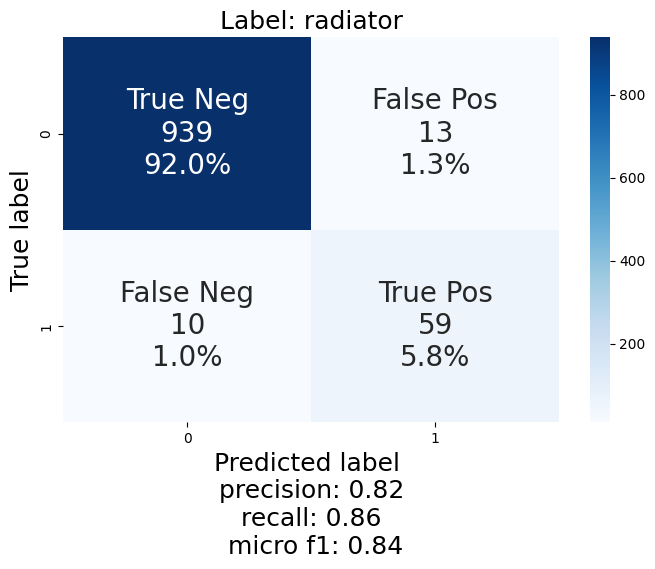

In [46]:
plot_cinfluence_for_one_label(label = 'radiator')